In [2]:
## Use SVM and SGD to attempt to model and predict the class of an internet connection request.
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier

# PREPROCESSING

In [3]:
df = pd.read_csv('log2.csv')
df.info()
pd.set_option('display.float_format', lambda x: '%.0f' % x)
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65532 entries, 0 to 65531
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Source Port           65532 non-null  int64 
 1   Destination Port      65532 non-null  int64 
 2   NAT Source Port       65532 non-null  int64 
 3   NAT Destination Port  65532 non-null  int64 
 4   Action                65532 non-null  object
 5   Bytes                 65532 non-null  int64 
 6   Bytes Sent            65532 non-null  int64 
 7   Bytes Received        65532 non-null  int64 
 8   Packets               65532 non-null  int64 
 9   Elapsed Time (sec)    65532 non-null  int64 
 10  pkts_sent             65532 non-null  int64 
 11  pkts_received         65532 non-null  int64 
dtypes: int64(11), object(1)
memory usage: 6.0+ MB


,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
count,65532,65532,65532,65532,65532,65532,65532,65532,65532,65532,65532
mean,49392,10577,19283,2671,97124,22386,74738,103,66,41,61
std,15256,18466,21971,9739,5618439,3828139,2463208,5133,302,3219,2223
min,0,0,0,0,60,60,0,1,0,1,0
25%,49183,80,0,0,66,66,0,1,0,1,0
50%,53776,445,8820,53,168,90,79,2,15,1,1
75%,58638,15000,38366,443,752,210,449,6,30,3,2
max,65534,65535,65535,65535,1269359015,948477220,320881795,1036116,10824,747520,327208


In [4]:
# Missing Data
df.isnull().sum()

Source Port             0
Destination Port        0
NAT Source Port         0
NAT Destination Port    0
Action                  0
Bytes                   0
Bytes Sent              0
Bytes Received          0
Packets                 0
Elapsed Time (sec)      0
pkts_sent               0
pkts_received           0
dtype: int64

In [5]:
# FIX VARIABLE NAMES
df = df.rename(columns={"Source Port": "source_port",
                        "Destination Port": "destination_port",
                        "NAT Source Port": "nat_source_port",
                        "NAT Destination Port": "nat_destination_port",
                        "Action": "action",
                        "Bytes": "bytes",
                        "Bytes Sent": "bytes_sent",
                        "Bytes Received": "bytes_received",
                        "Packets": "packets",
                        "Elapsed Time (sec)": "elapsed_time_sec",
                        "pkts_sent": "packets_sent",
                        "pkts_received": "packets_received"})

# FIX RESPONSE VARIABLE

In [6]:
print(df.action.value_counts())

allow         37640
deny          14987
drop          12851
reset-both       54
Name: action, dtype: int64


In [7]:

# Combine "drop" and "reset" = "deny"
# df['action'] = df['action'].map({'allow':'allow',
#                                  'deny':'deny',
#                                  'reset-both':'deny',
#                                  'drop':'deny'})
# Convert to numeric and categorical
df['action'] = df['action'].replace(['allow', 'deny', 'drop', 'reset-both'], [1, 0, 2, 3]).astype('category')
print(df.action.value_counts())

1    37640
0    14987
2    12851
3       54
Name: action, dtype: int64


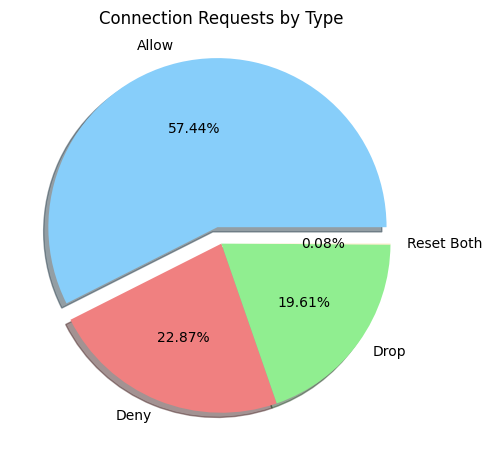

In [8]:
import matplotlib.pyplot as plt
# Plot of Spam Emails
pie_labels = 'Allow', 'Deny', 'Drop', 'Reset Both'
colors = ['lightskyblue', 'lightcoral','lightgreen', 'moccasin']
explode = (0.1, 0, 0, 0)
plt.figure(figsize=(12, 12))
plt.subplot(121)
df['action'].value_counts(dropna=False).plot.pie(
    autopct='%0.2f%%', labels=pie_labels, colors=colors, explode=explode, shadow=True)

plt.title("Connection Requests by Type")
plt.ylabel("")
plt.show()

# FIX CATEGORICAL VARIABLES

In [9]:
for times_accessed in range(1, 6):
    print("Percent of source_port accessed", times_accessed, " time(s): \t", 
          (len(df['source_port'].value_counts()[df['source_port'].value_counts() == times_accessed])/len(df["source_port"].value_counts()))*100)

    
for times_accessed in range(1, 6):
    print("Percent of destination_port accessed", times_accessed, " time(s): \t", 
          (len(df['destination_port'].value_counts()[df['destination_port'].value_counts() == times_accessed])/len(df["destination_port"].value_counts()))*100)
    
for times_accessed in range(1, 6):
    print("Percent of nat_source_port accessed", times_accessed, " time(s): \t", 
          (len(df['nat_source_port'].value_counts()[df['nat_source_port'].value_counts() == times_accessed])/len(df["nat_source_port"].value_counts()))*100)
    
for times_accessed in range(1, 6):
    print("Percent of nat_destination_port accessed", times_accessed, " time(s): \t", 
          (len(df['nat_destination_port'].value_counts()[df['nat_destination_port'].value_counts() == times_accessed])/len(df["nat_destination_port"].value_counts()))*100)

Percent of source_port accessed 1  time(s): 	 40.05456785777152
Percent of source_port accessed 2  time(s): 	 19.60922372821686
Percent of source_port accessed 3  time(s): 	 15.318605879246611
Percent of source_port accessed 4  time(s): 	 8.502024291497975
Percent of source_port accessed 5  time(s): 	 5.6416123921844745
Percent of destination_port accessed 1  time(s): 	 47.63214176596395
Percent of destination_port accessed 2  time(s): 	 32.81393217231897
Percent of destination_port accessed 3  time(s): 	 5.0412465627864345
Percent of destination_port accessed 4  time(s): 	 3.1164069660861595
Percent of destination_port accessed 5  time(s): 	 1.435991445157348
Percent of nat_source_port accessed 1  time(s): 	 76.87294182217343
Percent of nat_source_port accessed 2  time(s): 	 19.83397365532382
Percent of nat_source_port accessed 3  time(s): 	 2.9294731064764
Percent of nat_source_port accessed 4  time(s): 	 0.3258781558726674
Percent of nat_source_port accessed 5  time(s): 	 0.02401207

### source_port

In [10]:
df['source_port'].value_counts()

58638    840
27005    513
443      273
57470    222
49418    210
        ... 
32996      1
60574      1
60570      1
65368      1
54871      1
Name: source_port, Length: 22724, dtype: int64

In [11]:
ports_freqs = df['source_port'].value_counts()

ports_less_than_4 = ports_freqs[ports_freqs < 4].index
df['source_port'] = df['source_port'].replace(ports_less_than_4, 0)
df['source_port'].value_counts()

0        28630
58638      840
27005      513
443        273
57470      222
         ...  
51962        4
57996        4
51970        4
56485        4
64840        4
Name: source_port, Length: 5685, dtype: int64

### destination_port

In [12]:
df['destination_port'].value_counts()

53       15414
445      12891
443      11684
80        4035
25174     1087
         ...  
20009        1
48608        1
10016        1
13384        1
22455        1
Name: destination_port, Length: 3273, dtype: int64

In [13]:
ports_freqs = df['destination_port'].value_counts()

ports_less_than_4 = ports_freqs[ports_freqs < 3].index
df['destination_port'] = df['destination_port'].replace(ports_less_than_4, 0)
df['destination_port'].value_counts()

53       15414
445      12891
443      11684
80        4035
0         3880
         ...  
33058        3
36602        3
7363         3
37579        3
22617        3
Name: destination_port, Length: 640, dtype: int64

### nat_source_port

In [14]:
df['nat_source_port'].value_counts()

0        28432
48817       83
58638       51
50116       15
7986         5
         ...  
2063         1
33661        1
36797        1
14122        1
13485        1
Name: nat_source_port, Length: 29152, dtype: int64

In [15]:
ports_freqs = df['nat_source_port'].value_counts()

ports_less_than_4 = ports_freqs[ports_freqs < 3].index
df['nat_source_port'] = df['nat_source_port'].replace(ports_less_than_4, 0)
df['nat_source_port'].value_counts()

0        62406
48817       83
58638       51
50116       15
57596        5
         ...  
55689        3
61837        3
38830        3
63046        3
55530        3
Name: nat_source_port, Length: 960, dtype: int64

### nat_destination_port

In [16]:
df['nat_destination_port'].value_counts()

0        28432
53       15094
443      11678
80        4028
27015      234
         ...  
45561        1
45738        1
41872        1
25760        1
32277        1
Name: nat_destination_port, Length: 2533, dtype: int64

In [17]:
ports_freqs = df['nat_destination_port'].value_counts()

ports_less_than_4 = ports_freqs[ports_freqs < 3].index
df['nat_destination_port'] = df['nat_destination_port'].replace(ports_less_than_4, 0)
df['nat_destination_port'].value_counts()

0        31684
53       15094
443      11678
80        4028
27015      234
         ...  
48019        3
58695        3
1035         3
36498        3
40003        3
Name: nat_destination_port, Length: 267, dtype: int64

### Final Peek

In [18]:
categorical_cols = ['source_port','destination_port','nat_source_port','nat_destination_port']

for i in categorical_cols:
    df[i] = df[i].astype("category")

In [19]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65532 entries, 0 to 65531
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   source_port           65532 non-null  category
 1   destination_port      65532 non-null  category
 2   nat_source_port       65532 non-null  category
 3   nat_destination_port  65532 non-null  category
 4   action                65532 non-null  category
 5   bytes                 65532 non-null  int64   
 6   bytes_sent            65532 non-null  int64   
 7   bytes_received        65532 non-null  int64   
 8   packets               65532 non-null  int64   
 9   elapsed_time_sec      65532 non-null  int64   
 10  packets_sent          65532 non-null  int64   
 11  packets_received      65532 non-null  int64   
dtypes: category(5), int64(7)
memory usage: 4.3 MB


,bytes,bytes_sent,bytes_received,packets,elapsed_time_sec,packets_sent,packets_received
count,65532,65532,65532,65532,65532,65532,65532
mean,97124,22386,74738,103,66,41,61
std,5618439,3828139,2463208,5133,302,3219,2223
min,60,60,0,1,0,1,0
25%,66,66,0,1,0,1,0
50%,168,90,79,2,15,1,1
75%,752,210,449,6,30,3,2
max,1269359015,948477220,320881795,1036116,10824,747520,327208


# MODELS PREP

In [20]:
X = df.loc[:,df.columns !='action']
y = df['action']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

# SVM

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
import pandas as pd

numerical_cols = ['bytes', 'bytes_sent', 'bytes_received', 'packets', 'elapsed_time_sec', 'packets_sent', 'packets_received']
categorical_cols = ['source_port','destination_port','nat_source_port','nat_destination_port']


numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', SVC(
    random_state=42
    ))])

param_grid = {
    'classifier__C': [1 + x for x in range(403895, 403900)],
    'classifier__gamma': ['scale', 'auto']
}

grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=3)

grid_search.fit(X_train, y_train)

print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)


Best parameters:  {'classifier__C': 403898, 'classifier__gamma': 'scale'}
Best score:  0.9982641869337149


### Classification Repot

In [22]:
from sklearn.metrics import classification_report

preds = grid_search.predict(X_test)
print(classification_report(y_test, preds, target_names=['Allow', 'Deny', 'Drop', 'Reset Both']))

              precision    recall  f1-score   support

       Allow       1.00      1.00      1.00      2994
        Deny       1.00      1.00      1.00      7545
        Drop       1.00      1.00      1.00      2562
  Reset Both       1.00      1.00      1.00         6

    accuracy                           1.00     13107
   macro avg       1.00      1.00      1.00     13107
weighted avg       1.00      1.00      1.00     13107



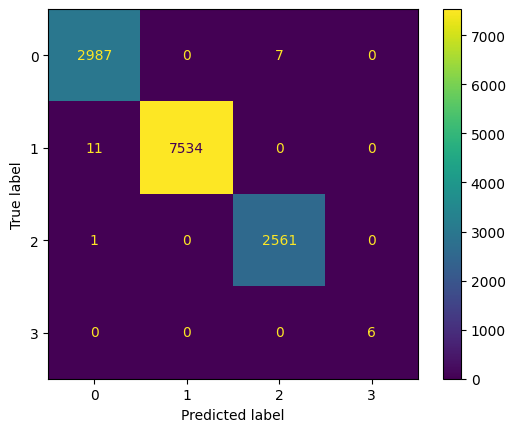

In [23]:
from sklearn.metrics import ConfusionMatrixDisplay

# Confusion matrix test
confusion_matrix(y_test, preds)
disp = ConfusionMatrixDisplay.from_estimator(grid_search, X_test, y_test)

# SGD

In [25]:
from sklearn.linear_model import SGDClassifier

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', SGDClassifier(
    early_stopping=True, 
    loss='squared_hinge',
    max_iter=999999,
    n_jobs=-1,
    random_state=42
    ))])

param_grid = {
    'classifier__penalty': ['l2', 'l1', 'elasticnet'],
    'classifier__l1_ratio': [0.0, 0.1, 0.2, 0.3, 0.4, 
                             0.5, 0.6, 0.7, 0.8, 0.9, 
                             1.0]
}

grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=3)

grid_search.fit(X_train, y_train)

print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best parameters:  {'classifier__l1_ratio': 0.3, 'classifier__penalty': 'elasticnet'}
Best score:  0.9955746304244159


In [26]:
from sklearn.metrics import classification_report

preds = grid_search.predict(X_test)
print(classification_report(y_test, preds, target_names=['Allow', 'Deny', 'Drop', 'Reset Both']))

              precision    recall  f1-score   support

       Allow       1.00      0.98      0.99      2994
        Deny       0.99      1.00      1.00      7545
        Drop       1.00      1.00      1.00      2562
  Reset Both       0.33      0.33      0.33         6

    accuracy                           0.99     13107
   macro avg       0.83      0.83      0.83     13107
weighted avg       0.99      0.99      0.99     13107



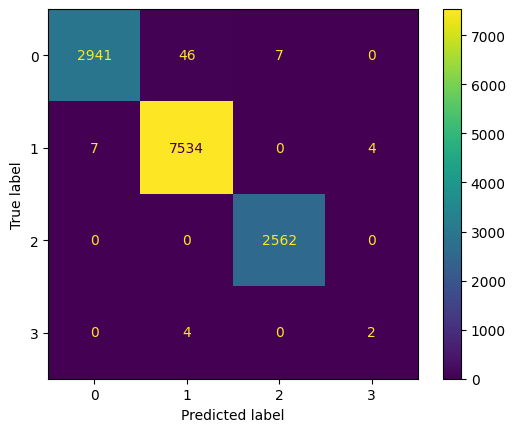

In [27]:
from sklearn.metrics import ConfusionMatrixDisplay

# Confusion matrix test
confusion_matrix(y_test, preds)
disp = ConfusionMatrixDisplay.from_estimator(grid_search, X_test, y_test)